# Table of Contents
 <p><div class="lev1"><a href="#Figures-for-AGU2017"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figures for AGU2017</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'plot2D', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [10]:
# time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
time_strides = '3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx','9dx'
N_times = len(time_strides)
N_res = len(resolutions)

print("choose run options")
scaling = 'omega500tsps'
compset = 'FSPCAMm_AMIP'
# compset = 'FAMIPC5'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
dates_label = '185005010100-185105010000'
ranks_label = 'Q8-Q41'
time_ref = '1d'
res_ref = '1dx'

# Results to analyze
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset)

results = {}
for time_stride in time_strides:
    results[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_dataframe_%s_%s.csv'%(ranks_label,dates_label)
        filepath = os.path.join(resultdir,time_stride,resolution,filename)
        results[time_stride][resolution] = pd.read_csv(filepath)

all_varids = results[time_ref][res_ref].keys()

choose run options


In [11]:
varids_to_remove = set(('Unnamed: 0','contrib','ranks_ref'))
varids_to_sum = set(('N_prQ',))
varids_to_avg = set(all_varids).difference(varids_to_remove.union(varids_to_sum))

In [12]:
print("load all variables as a function of time_stride and resolution")

ranks_ref = results[time_strides[0]][resolutions[0]]['ranks_ref']
iQ999 = indexOfRank(99.9,ranks_ref)
iQ_slice = slice(iQ999-5,iQ999+5)

iQ_label = "Q%d_Q%d"%(iQ_slice.start,iQ_slice.stop)

for varid in varids_to_avg:
    newvarid = "%s_%s"%(varid,iQ_label)
    newvar = getTXVarFromResults(varid,results,time_strides,resolutions,iQ_slice,avg_mode='mean')
    setattr(thismodule,newvarid,newvar)

for varid in ('N_prQ',):
    newvarid = "%s_Q%s"%(varid,iQ999)
    newvar = getTXVarFromResults(varid,results,time_strides,resolutions,slice(iQ999,iQ999+1),avg_mode='sum')
    setattr(thismodule,newvarid,newvar)


load all variables as a function of time_stride and resolution


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/global/u2/b/bfildier/code/dataAnalysis/extreme-rain-predictability-across-scales/functions/outputResults.py:77: RuntimeWarning: Mean of empty slice
  varidTX[ires,its] = np.nanmean(results[time_stride][resolution][varid][iQ_slice])


In [13]:
print("compute normalizes bias")
norm_bias_pr_sc_prQ_Q25_Q35 = 1-(pr_sc_vQ_Q25_Q35/pr_sc_prQ_Q25_Q35)

compute normalizes bias


In [14]:
print("sum of covariance terms")
contribQOmega_var_allcov_Q25_Q35 = contribQOmega_var_covQOmega_Q25_Q35+contribQOmega_var_covQ2Omega2_Q25_Q35
contribTOmega_var_allcov_Q25_Q35 = contribTOmega_var_covTOmega_Q25_Q35+contribTOmega_var_covTOmega2_Q25_Q35

sum of covariance terms


In [15]:
print("> Plot normalized variability and contributions")

varids_to_plot = [v for v in locals() if v.endswith(iQ_label) and v.startswith('contrib')]

## Plot bias and variability
for varid in ['norm_bias_pr_sc_prQ_Q25_Q35','norm_var_pr_sc_prQ_Q25_Q35']:
    var = getattr(thismodule,varid)
    # Plot
    fig, ax = plt.subplots(ncols=1,nrows=1)
    if varid.startswith('norm_var_'):
        vmin = 0; vmax = 0.13
        subplotMultiscaleVar(ax,var,time_strides,cmap=plt.cm.Spectral,vmin=vmin,vmax=vmax)
        ax.set_title('Normalized variance')
    elif varid.startswith('norm_bias_'):
        subplotMultiscaleVar(ax,var,time_strides)
        ax.set_title('Normalized bias')
    addHatchBelowThreshold(ax,N_prQ_Q30,40)
    plt.savefig(os.path.join(figdir,'%s_%s.pdf'%(varid,dates_label.replace('-','_'))),bbox_inches='tight')
    plt.close()

## Plot all contributions
for varid in varids_to_plot:
    if '_var_' in varid:
        var = getattr(thismodule,varid)/norm_var_pr_sc_prQ_Q25_Q35*100
    elif '_bias_' in varid:
        var = getattr(thismodule,varid)/norm_bias_pr_sc_prQ_Q25_Q35*100
    # Plot
    fig, ax = plt.subplots(ncols=1,nrows=1)
    subplotMultiscaleVar(ax,var,time_strides,cmap=plt.cm.Spectral,vmin=-120,vmax=120)
    addHatchBelowThreshold(ax,N_prQ_Q30,40)
    plt.savefig(os.path.join(figdir,'fraction_%s_%s.pdf'%(varid,dates_label.replace('-','_'))),bbox_inches='tight')
    plt.close()


> Plot normalized variability and contributions


In [16]:
varids_to_plot

['contribTOmega_var_varOmega_Q25_Q35',
 'contribTOmega_var_sum_Q25_Q35',
 'contribQOmega_var_cov2QOmega_Q25_Q35',
 'contribQOmega_var_covQ2Omega2_Q25_Q35',
 'contribQOmega_var_covQOmega_Q25_Q35',
 'contribTOmega_var_covTOmega2_Q25_Q35',
 'contribTOmega_var_varT_Q25_Q35',
 'contribQOmega_var_sum_Q25_Q35',
 'contribQOmega_var_varOmega_Q25_Q35',
 'contribQOmega_var_varQvarOmega_Q25_Q35',
 'contribTOmega_var_covTOmega_Q25_Q35',
 'contribQOmega_var_varQ_Q25_Q35',
 'contribQOmega_bias_covQOmega_Q25_Q35',
 'contribQOmega_var_allcov_Q25_Q35',
 'contribTOmega_var_allcov_Q25_Q35']

In [17]:
## Draw isocontour samplesize = N_ref
N_ref = 150
x = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],1)
y = N_ref

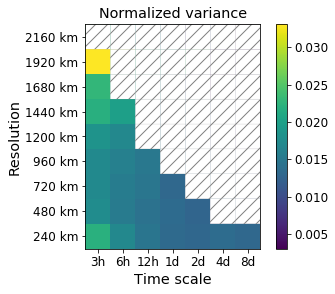

In [18]:
var = norm_var_pr_sc_prQ_Q25_Q35
fig, ax = plt.subplots(ncols=1,nrows=1)
cb = subplotMultiscaleVar(ax,var,time_strides)
ax.set_title('Normalized variance')

addHatchBelowThreshold(ax,N_prQ_Q30,40)